## Tempe Logistic Regression (Classification Proof of Concept)
###### Code by Drew Gobbi - 11/30/19

### Import Packages and Data Cleaning

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from time import strptime
import os 
import patsy 
from shapely.wkt import loads

In [2]:
#tempe ems 
eurl = 'https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Opioid_Calls/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token='
tempems = gpd.read_file(eurl)
tempems.to_csv('tempems.csv')

In [3]:
tempems.head()

,OBJECTID,Incident_Date,Weekday,Weekday_Sort,Month,Month_Sort,Year,Opioid_Use,Narcan_Given,Age,Patient_Gender,Patient_ASU,Patient_Veteran,Patient_Homeless,Latitude_Random,Longitude_Random,Spec_Pop,Notes,Time_of_Day,geometry
0,1,1483401600000,Tuesday,(3) Tuesday,January,(01) January,2017,Yes,NULL,40 to 44,Female,No,No,No,33.4196,-111.8904,None,None,Morning,POINT (-111.89040 33.41960)
1,2,1483920000000,Monday,(2) Monday,January,(01) January,2017,Unknown,Yes,40 to 44,Male,No,No,No,33.4127,-111.9505,None,None,Overnight,POINT (-111.95050 33.41270)
2,3,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,20 to 24,Male,No,No,Yes,33.3971,-111.9249,Homeless,None,Overnight,POINT (-111.92490 33.39710)
3,4,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,20 to 24,Male,No,No,Yes,33.4297,-111.9334,Homeless,None,Morning,POINT (-111.93340 33.42970)
4,5,1483920000000,Monday,(2) Monday,January,(01) January,2017,Yes,NULL,70 to 74,Male,No,No,No,33.3681,-111.9014,None,None,Afternoon,POINT (-111.90140 33.36810)


In [4]:
tempems.dtypes

OBJECTID               int64
Incident_Date          int64
Weekday               object
Weekday_Sort          object
Month                 object
Month_Sort            object
Year                   int64
Opioid_Use            object
Narcan_Given          object
Age                   object
Patient_Gender        object
Patient_ASU           object
Patient_Veteran       object
Patient_Homeless      object
Latitude_Random      float64
Longitude_Random     float64
Spec_Pop              object
Notes                 object
Time_of_Day           object
geometry            geometry
dtype: object

In [5]:
tempems = tempems[tempems['Opioid_Use'] == 'Yes']

In [6]:
#city planning data
tempe = gpd.read_file("https://services.arcgis.com/lQySeXwbBg53XWDi/arcgis/rest/services/Map/FeatureServer/0/query?where=OBJECTID+%3E+0+&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&resultType=none&distance=0.0&units=esriSRUnit_Meter&returnGeodetic=false&outFields=*&returnGeometry=true&returnCentroid=false&featureEncoding=esriDefault&multipatchOption=xyFootprint&maxAllowableOffset=&geometryPrecision=&outSR=4326&datumTransformation=&applyVCSProjection=false&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&returnQueryGeometry=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&returnZ=false&returnM=false&returnExceededLimitFeatures=true&quantizationParameters=&sqlFormat=none&f=pgeojson&token=")

In [7]:
tempe.head()

,OBJECTID,TempeTracts_STATEFP,TempeTracts_COUNTYFP,TempeTracts_TRACTCE,TempeTracts_GEOID,TempeTracts_NAME,TempeTracts_NAMELSAD,TempeTracts_MTFCC,TempeTracts_FUNCSTAT,TempeTracts_ALAND,...,pdb2018trv4_us_csv_pct_Vacants_,pdb2018trv4_us_csv_pct_Deletes_,pdb2018trv4_us_csv_pct_Census_U,pdb2018trv4_us_csv_pct_Mailback,pdb2018trv4_us_csv_pct_FRST_FRM,pdb2018trv4_us_csv_pct_RPLCMNT_,pdb2018trv4_us_csv_pct_BILQ_Mai,Shape__Area,Shape__Length,geometry
0,1,04,013,318800,04013318800,3188,Census Tract 3188,G5020,S,2569382,...,2.84,0,21.21,75.95,40.84,8.94,NaN,2.770706e+07,21462.867389,"POLYGON ((-111.96132 33.43719, -111.96132 33.4..."
1,2,04,013,319101,04013319101,3191.01,Census Tract 3191.01,G5020,S,330646,...,1.94,0,24.12,73.94,32.04,8.81,NaN,3.558325e+06,8618.283373,"POLYGON ((-111.92629 33.41915, -111.92611 33.4..."
2,3,04,013,318900,04013318900,3189,Census Tract 3189,G5020,S,2589083,...,3.04,0,9.56,87.41,58.33,6.86,NaN,2.786309e+07,21120.878745,"POLYGON ((-111.96090 33.42195, -111.95857 33.4..."
3,4,04,013,319000,04013319000,3190,Census Tract 3190,G5020,S,2588739,...,14.36,0,9.11,76.53,49.79,5.07,NaN,2.785941e+07,21103.097728,"POLYGON ((-111.94358 33.41505, -111.94357 33.4..."
4,5,04,013,319403,04013319403,3194.03,Census Tract 3194.03,G5020,S,2657428,...,5.68,0,4.26,90.06,66.37,0.00,NaN,2.869570e+07,21428.155647,"POLYGON ((-111.90912 33.39411, -111.90912 33.3..."


In [8]:
tempe.to_csv('tempe.csv')

In [9]:
tempems.shape

(745, 20)

In [10]:
tempems['Month'] = tempems['Month'].apply(lambda x: strptime(x,'%B').tm_mon)
tempems["date"] = tempems["Year"].map(str) + '-' + tempems["Month"].map(str)
tempems["date"] = pd.to_datetime(tempems["date"])

In [11]:
tempe_tract = pd.DataFrame()
for i in range(len(tempe)):
    df = tempems[tempems.within(tempe.loc[i,'geometry'])]
    df['tract'] = tempe.loc[i,'TempeTracts_NAME']
    tempe_tract = pd.concat([tempe_tract, df], axis=0)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [12]:
tempe_tract

,OBJECTID,Incident_Date,Weekday,Weekday_Sort,Month,Month_Sort,Year,Opioid_Use,Narcan_Given,Age,...,Patient_Veteran,Patient_Homeless,Latitude_Random,Longitude_Random,Spec_Pop,Notes,Time_of_Day,geometry,date,tract
28,29,1485734400000,Monday,(2) Monday,1,(01) January,2017,Yes,Yes,25 to 29,...,Yes,No,33.4279,-111.9591,Veteran,None,Evening,POINT (-111.95910 33.42790),2017-01-01,3188
97,98,1491177600000,Monday,(2) Monday,4,(04) April,2017,Yes,NULL,15 to 19,...,Yes,Yes,33.4338,-111.9449,Veteran/Homeless,None,Overnight,POINT (-111.94490 33.43380),2017-04-01,3188
110,111,1491868800000,Tuesday,(3) Tuesday,4,(04) April,2017,Yes,NULL,20 to 24,...,Unknown,No,33.4271,-111.9495,None,None,Morning,POINT (-111.94950 33.42710),2017-04-01,3188
166,167,1495238400000,Saturday,(7) Saturday,5,(05) May,2017,Yes,Yes,25 to 29,...,Unknown,No,33.4288,-111.9567,None,None,Morning,POINT (-111.95670 33.42880),2017-05-01,3188
191,192,1496707200000,Tuesday,(3) Tuesday,6,(06) June,2017,Yes,NULL,55 to 59,...,Unknown,No,33.4316,-111.9480,None,None,Morning,POINT (-111.94800 33.43160),2017-06-01,3188
215,216,1498521600000,Tuesday,(3) Tuesday,6,(06) June,2017,Yes,NULL,25 to 29,...,No,No,33.4314,-111.9504,None,None,Afternoon,POINT (-111.95040 33.43140),2017-06-01,3188
253,254,1500768000000,Sunday,(1) Sunday,7,(07) July,2017,Yes,NULL,30 to 34,...,No,No,33.4230,-111.9442,None,None,Overnight,POINT (-111.94420 33.42300),2017-07-01,3188
278,279,1501891200000,Saturday,(7) Saturday,8,(08) August,2017,Yes,Yes,25 to 29,...,Unknown,Unknown,33.4255,-111.9559,None,None,Evening,POINT (-111.95590 33.42550),2017-08-01,3188
283,284,1502668800000,Monday,(2) Monday,8,(08) August,2017,Yes,NULL,25 to 29,...,No,No,33.4272,-111.9542,None,None,Afternoon,POINT (-111.95420 33.42720),2017-08-01,3188
384,385,1510531200000,Monday,(2) Monday,11,(11) November,2017,Yes,Yes,20 to 24,...,Yes,No,33.4241,-111.9532,Veteran,None,Afternoon,POINT (-111.95320 33.42410),2017-11-01,3188


In [13]:
tempe_tract = tempe_tract.merge(tempe, left_on='tract', right_on='TempeTracts_NAME')

In [14]:
tempe_tract.drop('geometry_y', inplace=True, axis=1)

In [15]:
tempe_tract.rename(columns={'geometry_x':'geometry'}, inplace=True)
tempe_tract = gpd.GeoDataFrame(tempe_tract, geometry=tempe_tract.geometry)

In [16]:
mt = tempe_tract.groupby([tempe_tract['date'].dt.year.rename('year'), tempe_tract['date'].dt.month.rename('month'), 
                          tempe_tract['tract']]).agg({'count'})
mt = mt['Opioid_Use']
mt.reset_index(inplace=True)

mt.rename(columns={'count': 'ems_call'}, inplace=True)
tempe_tract['year'] = tempe_tract['date'].dt.year
tempe_tract['month'] = tempe_tract['date'].dt.month

tempe_tract = mt.merge(tempe_tract, on=['year', 'month', 'tract'])

In [17]:
tempe_tract.shape

(675, 496)

In [18]:
os.getcwd()

'/Users/drewgobbi/Documents/GitHub/OpioidWasteWaterPilot'

In [19]:
tempe_fac = pd.read_csv('TEMPEcntMedicalFacilitiesWithin2milesByTract.csv')

In [20]:
tempe_fac.dtypes

Unnamed: 0                         int64
TempeTracts_Name                 float64
HospitalsGeneralCount2mi           int64
HospitalsPsychCount2mi             int64
SurgicalCentersCount2mi            int64
UrgentCareCount2mi                 int64
WomensClinicsCount2mi              int64
PainManagementCount2mi             int64
PhysicalTherapyCount2mi            int64
MentalFacilitiesCount2mi           int64
SubstanceAbuseCount2mi             int64
OtherMedicalFacilitesCount2mi      int64
NursingAssistedLiveCount2mi        int64
HospiceCount2mi                    int64
ChildFacilitiesCount2mi            int64
PharmCount2mi                      int64
DrugDropCount2mi                   int64
NaloxoneDistribCount2mi            int64
geometry                          object
dtype: object

In [21]:
tempe_tract.TempeTracts_NAME = tempe_tract.TempeTracts_NAME.astype(float)

In [22]:
df = tempe_tract.merge(tempe_fac, left_on='TempeTracts_NAME', right_on='TempeTracts_Name')

In [23]:
df.drop('geometry_y', inplace=True, axis=1)

In [24]:
df['year_month'] = df['year'] + df['month']/100

In [25]:
df['year_month'].head()

0    2017.01
1    2017.01
2    2017.01
3    2017.02
4    2017.02
Name: year_month, dtype: float64

In [26]:
df['ems_flag'] = 0 
for i in range(len(df)):
    if df['ems_call'][i] >np.median(df['ems_call']):
        df['ems_flag'][i] =1

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [27]:
a = ['Shape__Area', 'Shape__Length', 'year', 'month', 'Unnamed: 0', 'OBJECTID_x', 'Incident_Date', 'Weekday',
         'Weekday_Sort', 'Month', 'Month_Sort', 'Year', 'Opioid_Use', 'Latitude_Random', 'Longitude_Random',
         'Spec_Pop', 'Notes', 'Time_of_Day', 'geometry_x', 'date', 'tract', 'OBJECTID_y', 'TempeTracts_STATEFP',
         'TempeTracts_COUNTYFP', 'TempeTracts_TRACTCE', 'TempeTracts_GEOID', 'TempeTracts_NAMELSAD',
         'TempeTracts_MTFCC', 'TempeTracts_FUNCSTAT', 'TempeTracts_ALAND', 'TempeTracts_AWATER', 'TempeTracts_INTPTLAT',
    'TempeTracts_INTPTLON', 'TempeTracts_TractNo', 'TempeTracts_GeoTrack']





In [28]:
df.drop(columns=a, inplace=True, axis=1)

### Logit

In [29]:
df.ems_flag.value_counts()

0    492
1    183
Name: ems_flag, dtype: int64

In [30]:
X = pd.get_dummies(df, drop_first=True)

In [31]:
b = ['Patient_Gender_NULL', 'Patient_Gender_Unknown (Unable to Determine)', 'Patient_ASU_Unknown',
    'Patient_Veteran_Unknown', 'Patient_Homeless_Unknown', 'pdb2018trv4_us_csv_GIDTR', 'pdb2018trv4_us_csv_State',
     'pdb2018trv4_us_csv_County', 'pdb2018trv4_us_csv_TRACTCE']

In [32]:
X.drop(columns=b, inplace=True, axis=1)

In [33]:
var = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
       'ems_flag']


In [34]:
fac = ['HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',
'ems_flag']

In [35]:
X1 = X.filter(var)
X1.drop_duplicates(inplace=True)

In [36]:
y = X1.ems_flag
X1.drop(columns='ems_flag', inplace=True)

In [37]:
#just regressors 
res = sm.Logit(y, X1).fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.557413
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                   50
Model:                          Logit   Df Residuals:                       45
Method:                           MLE   Df Model:                            4
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                 0.05994
Time:                        14:32:11   Log-Likelihood:                -27.871
converged:                       True   LL-Null:                       -29.648
                                        LLR p-value:                    0.4697
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_ -1.503e-05   2.66e-05     -0.566      0.572   -6.71e-05     3.7e-05
pdb2018trv4_us_csv_pct_Males_AC     0.0609      0.072      0.842      0.400      -0.081       0.203
pdb2018trv4_us_csv_pct_Pop_18_2     0.0040      0.032      0.125      0.900      -0.058       0.066
pdb2018trv4_us_csv_pct_Pop_25_4    -0.0751      0.076     -0.987      0.324      -0.224       0.074
pdb2018trv4_us_csv_pct_College_    -0.0337      0.048     -0.704      0.481      -0.127       0.060
===================================================================================================
"""

In [38]:
np.exp(res.params)

pdb2018trv4_us_csv_Med_HHD_Inc_    0.999985
pdb2018trv4_us_csv_pct_Males_AC    1.062832
pdb2018trv4_us_csv_pct_Pop_18_2    1.003989
pdb2018trv4_us_csv_pct_Pop_25_4    0.927687
pdb2018trv4_us_csv_pct_College_    0.966894
dtype: float64

In [39]:
X2 = X.filter(fac)

In [40]:
X2.drop_duplicates(inplace=True)
y = X2.ems_flag
X2.drop(columns='ems_flag', inplace=True)

In [41]:
#just facilities 
res = sm.Logit(y, X2).fit()
res.summary()

         Current function value: 0.486247
         Iterations: 35


/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                   50
Model:                          Logit   Df Residuals:                       34
Method:                           MLE   Df Model:                           15
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                  0.1800
Time:                        14:32:11   Log-Likelihood:                -24.312
converged:                      False   LL-Null:                       -29.648
                                        LLR p-value:                    0.7756
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
HospitalsGeneralCount2mi          2.2643      1.879      1.205      0.228      -1.418       5.946
HospitalsPsychCount2mi            0.4023      2.118      0.190      0.849      -3.748       4.553
SurgicalCentersCount2mi           2.2177      1.798      1.233      0.217      -1.307       5.742
UrgentCareCount2mi               -0.2530      1.331     -0.190      0.849      -2.862       2.356
WomensClinicsCount2mi           -19.8599   8185.153     -0.002      0.998   -1.61e+04     1.6e+04
PainManagementCount2mi           -4.8749      3.114     -1.565      0.117     -10.978       1.229
PhysicalTherapyCount2mi          -0.5939      1.185     -0.501      0.616      -2.917       1.729
MentalFacilitiesCount2mi          1.3796      1.441      0.957      0.338      -1.445       4.205
SubstanceAbuseCount2mi           -1.7189      1.646     -1.044      0.296      -4.945       1.507
OtherMedicalFacilitesCount2mi    -0.0780      0.354     -0.220      0.826      -0.772       0.616
NursingAssistedLiveCount2mi      -0.1619      0.213     -0.761      0.446      -0.579       0.255
HospiceCount2mi                  -1.0386      1.342     -0.774      0.439      -3.669       1.591
ChildFacilitiesCount2mi          -0.5305      0.525     -1.010      0.313      -1.560       0.499
PharmCount2mi                     0.0149      0.225      0.066      0.947      -0.426       0.456
DrugDropCount2mi                  1.5063      0.996      1.512      0.131      -0.447       3.459
NaloxoneDistribCount2mi          -0.5789      0.563     -1.028      0.304      -1.682       0.524
=================================================================================================
"""

In [42]:
v = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
'ems_flag', 
'HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',]


In [43]:
Xall = X.filter(v)
Xall.drop_duplicates(inplace=True)
y = Xall.ems_flag
Xall.drop(columns='ems_flag', inplace=True)

In [44]:
#everything
res = sm.Logit(y, Xall).fit()
res.summary()

         Current function value: 0.447608
         Iterations: 35


/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               ems_flag   No. Observations:                   50
Model:                          Logit   Df Residuals:                       29
Method:                           MLE   Df Model:                           20
Date:                Sun, 01 Dec 2019   Pseudo R-squ.:                  0.2451
Time:                        14:32:11   Log-Likelihood:                -22.380
converged:                      False   LL-Null:                       -29.648
                                        LLR p-value:                    0.8024
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_   -2.7e-05   4.73e-05     -0.571      0.568      -0.000    6.56e-05
pdb2018trv4_us_csv_pct_Males_AC     0.1146      0.149      0.769      0.442      -0.177       0.407
pdb2018trv4_us_csv_pct_Pop_18_2    -0.0197      0.073     -0.268      0.788      -0.163       0.124
pdb2018trv4_us_csv_pct_Pop_25_4    -0.2078      0.213     -0.975      0.329      -0.626       0.210
pdb2018trv4_us_csv_pct_College_    -0.1129      0.108     -1.047      0.295      -0.324       0.098
HospitalsGeneralCount2mi            2.0986      2.518      0.834      0.405      -2.836       7.033
HospitalsPsychCount2mi              3.1452      4.151      0.758      0.449      -4.991      11.282
SurgicalCentersCount2mi             3.3117      2.675      1.238      0.216      -1.932       8.555
UrgentCareCount2mi                 -0.8779      2.125     -0.413      0.680      -5.044       3.288
WomensClinicsCount2mi             -20.8301   8515.308     -0.002      0.998   -1.67e+04    1.67e+04
PainManagementCount2mi             -6.8907      5.446     -1.265      0.206     -17.566       3.784
PhysicalTherapyCount2mi            -1.2898      1.741     -0.741      0.459      -4.703       2.123
MentalFacilitiesCount2mi            3.0082      2.887      1.042      0.297      -2.651       8.667
SubstanceAbuseCount2mi             -3.2106      3.236     -0.992      0.321      -9.552       3.131
OtherMedicalFacilitesCount2mi       0.2305      0.598      0.386      0.700      -0.941       1.402
NursingAssistedLiveCount2mi         0.0236      0.279      0.084      0.933      -0.523       0.570
HospiceCount2mi                    -1.2748      2.153     -0.592      0.554      -5.495       2.945
ChildFacilitiesCount2mi            -1.1288      0.927     -1.218      0.223      -2.945       0.688
PharmCount2mi                       0.2371      0.412      0.575      0.565      -0.571       1.045
DrugDropCount2mi                    2.6609      1.822      1.461      0.144      -0.910       6.231
NaloxoneDistribCount2mi            -1.0814      0.975     -1.110      0.267      -2.992       0.829
===================================================================================================
"""

#### Discussion 
Results of all three experiments show a pseudo R2 below 10%, suggesting that our logit model does not explain a sufficient amount of the  variation to be explanatory.

### Poisson Regression

In [45]:
v = ['pdb2018trv4_us_csv_Med_HHD_Inc_', 
'pdb2018trv4_us_csv_pct_Males_AC',
'pdb2018trv4_us_csv_pct_Pop_18_2',
'pdb2018trv4_us_csv_pct_Pop_25_4',
'pdb2018trv4_us_csv_pct_College_',
'ems_call',
'year_month',
'TempeTracts_NAME', 
'HospitalsGeneralCount2mi',
'HospitalsPsychCount2mi',
'SurgicalCentersCount2mi',
'UrgentCareCount2mi',
'WomensClinicsCount2mi',
'PainManagementCount2mi',
'PhysicalTherapyCount2mi',
'MentalFacilitiesCount2mi',
'SubstanceAbuseCount2mi',
'OtherMedicalFacilitesCount2mi',
'NursingAssistedLiveCount2mi',
'HospiceCount2mi',
'ChildFacilitiesCount2mi',
'PharmCount2mi',
'DrugDropCount2mi',
'NaloxoneDistribCount2mi',]

In [46]:
df = X.filter(v)

In [47]:
df.drop_duplicates(inplace=True)

In [48]:
len(df)

440

In [49]:
df['ymt'] = df.year_month.astype(str) + '__' + df['TempeTracts_NAME'].astype(str)

In [50]:
df.set_index('ymt', inplace=True)

In [51]:
df.drop(columns=['year_month', 'TempeTracts_NAME'], inplace=True)

In [52]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=356
Testing data set length=84


In [53]:
y_train, X_train = df_train.ems_call, df_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = df_test.ems_call, df_test
X_test.drop(columns='ems_call', inplace=True)

/Users/drewgobbi/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [54]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                  356
Model:                            GLM   Df Residuals:                      335
Model Family:                 Poisson   Df Model:                           20
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -464.65
Date:                Sun, 01 Dec 2019   Deviance:                       118.60
Time:                        14:32:12   Pearson chi2:                     136.
No. Iterations:                     4   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_  6.909e-06   5.28e-06      1.308      0.191   -3.44e-06    1.73e-05
pdb2018trv4_us_csv_pct_Males_AC     0.0212      0.014      1.506      0.132      -0.006       0.049
pdb2018trv4_us_csv_pct_Pop_18_2     0.0009      0.007      0.129      0.897      -0.013       0.015
pdb2018trv4_us_csv_pct_Pop_25_4    -0.0197      0.016     -1.248      0.212      -0.051       0.011
pdb2018trv4_us_csv_pct_College_    -0.0194      0.008     -2.523      0.012      -0.034      -0.004
HospitalsGeneralCount2mi            0.1242      0.184      0.673      0.501      -0.237       0.486
HospitalsPsychCount2mi              0.1809      0.283      0.639      0.523      -0.374       0.736
SurgicalCentersCount2mi             0.0195      0.197      0.099      0.921      -0.366       0.405
UrgentCareCount2mi                 -0.1247      0.190     -0.656      0.512      -0.497       0.248
WomensClinicsCount2mi              -0.7048      0.688     -1.025      0.305      -2.053       0.643
PainManagementCount2mi             -0.3166      0.250     -1.268      0.205      -0.806       0.173
PhysicalTherapyCount2mi             0.0739      0.174      0.425      0.671      -0.267       0.415
MentalFacilitiesCount2mi            0.1283      0.138      0.928      0.353      -0.143       0.399
SubstanceAbuseCount2mi             -0.1060      0.143     -0.744      0.457      -0.385       0.173
OtherMedicalFacilitesCount2mi      -0.0485      0.042     -1.142      0.253      -0.132       0.035
NursingAssistedLiveCount2mi         0.0134      0.033      0.401      0.688      -0.052       0.079
HospiceCount2mi                     0.0503      0.170      0.295      0.768      -0.284       0.384
ChildFacilitiesCount2mi            -0.0578      0.051     -1.132      0.258      -0.158       0.042
PharmCount2mi                       0.0368      0.036      1.017      0.309      -0.034       0.108
DrugDropCount2mi                    0.3187      0.084      3.779      0.000       0.153       0.484
NaloxoneDistribCount2mi            -0.1353      0.068     -2.001      0.045      -0.268      -0.003
===================================================================================================
"""

In [55]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
ymt,,,,
2017.05__3184.0,2.647840,0.304973,2.112770,3.318420
2018.06__3184.0,2.647840,0.304973,2.112770,3.318420
2019.01__3184.0,2.647840,0.304973,2.112770,3.318420
2017.06__3187.0,2.212418,0.307945,1.684182,2.906333
2017.09__3187.0,2.212418,0.307945,1.684182,2.906333


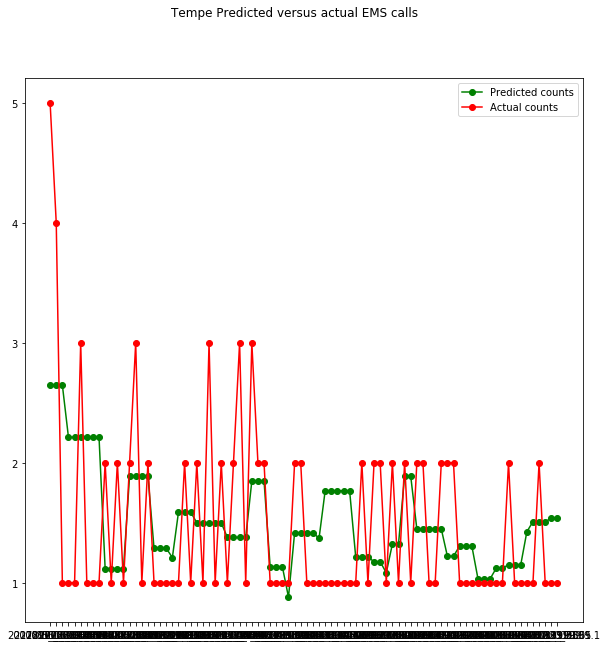

<Figure size 432x288 with 0 Axes>

In [56]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Tempe Predicted versus actual EMS calls')
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Tempe_EMS_poisson')

#### Add Fixed Effects 

In [57]:
len(predictions_summary_frame['mean'])

84

In [58]:
len(y_test)

84

In [59]:
len(tempems)

745

In [60]:
df2 = X.filter(v)

In [61]:
df2.head()

,pdb2018trv4_us_csv_Med_HHD_Inc_,pdb2018trv4_us_csv_pct_Males_AC,pdb2018trv4_us_csv_pct_Pop_18_2,pdb2018trv4_us_csv_pct_Pop_25_4,pdb2018trv4_us_csv_pct_College_,ems_call,year_month,TempeTracts_NAME,HospitalsGeneralCount2mi,HospitalsPsychCount2mi,...,PhysicalTherapyCount2mi,MentalFacilitiesCount2mi,SubstanceAbuseCount2mi,OtherMedicalFacilitesCount2mi,NursingAssistedLiveCount2mi,HospiceCount2mi,ChildFacilitiesCount2mi,PharmCount2mi,DrugDropCount2mi,NaloxoneDistribCount2mi
0,43300,51.36,28.65,33.12,27.02,3,2017.01,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
1,43300,51.36,28.65,33.12,27.02,3,2017.01,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
2,43300,51.36,28.65,33.12,27.02,3,2017.01,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
3,43300,51.36,28.65,33.12,27.02,5,2017.02,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5
4,43300,51.36,28.65,33.12,27.02,5,2017.02,3184.0,0,0,...,1,4,2,4,1,0,0,7,4,5


In [62]:
df2.drop_duplicates(inplace=True)

In [63]:
df2['ymt'] = df2.year_month.astype(str) + '__' + df2['TempeTracts_NAME'].astype(str)
df2.set_index('ymt', inplace=True)

In [64]:
df2 = pd.get_dummies(df2, columns=['year_month', 'TempeTracts_NAME'], drop_first=True)

In [65]:
#https://towardsdatascience.com/an-illustrated-guide-to-the-poisson-regression-model-50cccba15958
mask = np.random.rand(len(df2)) < 0.8
df2_train = df2[mask]
df2_test = df2[~mask]
print('Training data set length='+str(len(df2_train)))
print('Testing data set length='+str(len(df2_test)))

Training data set length=363
Testing data set length=77


In [66]:
y_train, X_train = df2_train.ems_call, df2_train
X_train.drop(columns='ems_call', inplace=True)

y_test, X_test = df2_test.ems_call, df2_test
X_test.drop(columns='ems_call', inplace=True)

In [67]:
res = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               ems_call   No. Observations:                  363
Model:                            GLM   Df Residuals:                      296
Model Family:                 Poisson   Df Model:                           66
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -458.43
Date:                Sun, 01 Dec 2019   Deviance:                       91.849
Time:                        14:32:13   Pearson chi2:                     99.0
No. Iterations:                     4   Covariance Type:             nonrobust
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
pdb2018trv4_us_csv_Med_HHD_Inc_  1.324e-05   6.73e-06      1.967      0.049    5.05e-08    2.64e-05
pdb2018trv4_us_csv_pct_Males_AC     0.0077      0.015      0.519      0.604      -0.021       0.037
pdb2018trv4_us_csv_pct_Pop_18_2     0.0069      0.009      0.755      0.450      -0.011       0.025
pdb2018trv4_us_csv_pct_Pop_25_4     0.0011      0.017      0.063      0.950      -0.033       0.035
pdb2018trv4_us_csv_pct_College_    -0.0229      0.010     -2.285      0.022      -0.043      -0.003
HospitalsGeneralCount2mi            0.0036      0.133      0.027      0.978      -0.258       0.265
HospitalsPsychCount2mi             -0.0029      0.210     -0.014      0.989      -0.414       0.408
SurgicalCentersCount2mi            -0.0820      0.166     -0.495      0.621      -0.407       0.243
UrgentCareCount2mi                 -0.0941      0.156     -0.602      0.547      -0.400       0.212
WomensClinicsCount2mi              -0.2076      0.218     -0.951      0.341      -0.635       0.220
PainManagementCount2mi             -0.0156      0.200     -0.078      0.938      -0.407       0.376
PhysicalTherapyCount2mi             0.1208      0.171      0.709      0.479      -0.213       0.455
MentalFacilitiesCount2mi           -0.0544      0.167     -0.326      0.745      -0.381       0.273
SubstanceAbuseCount2mi              0.0521      0.145      0.359      0.720      -0.232       0.336
OtherMedicalFacilitesCount2mi      -0.0417      0.042     -0.984      0.325      -0.125       0.041
NursingAssistedLiveCount2mi        -0.0047      0.043     -0.109      0.914      -0.090       0.080
HospiceCount2mi                     0.1015      0.165      0.615      0.539      -0.222       0.425
ChildFacilitiesCount2mi            -0.0214      0.046     -0.470      0.638      -0.111       0.068
PharmCount2mi                       0.0244      0.038      0.648      0.517      -0.049       0.098
DrugDropCount2mi                    0.2229      0.084      2.650      0.008       0.058       0.388
NaloxoneDistribCount2mi            -0.0672      0.068     -0.993      0.321      -0.200       0.065
year_month_2017.02                 -0.0058      0.307     -0.019      0.985      -0.607       0.595
year_month_2017.03                  0.1820      0.347      0.524      0.600      -0.499       0.863
year_month_2017.04                  0.2622      0.293      0.894      0.372      -0.313       0.837
year_month_2017.05                  0.1019      0.306      0.333      0.739      -0.498       0.701
year_month_2017.06                 -0.0170      0.324     -0.052      0.958      -0.652       0.618
year_month_2017.07                  0.3356      0.280      1.197      0.231      -0.214       0.885
year_month_2017.08                 -0.1018      0.315     -0.323      0.746      -0.719       0.515
year_month_2017.09                 -0.1856      0.373     -0.4

In [68]:
poisson_predictions = res.get_prediction(X_test)
#.summary_frame() returns a pandas DataFrame
predictions_summary_frame = poisson_predictions.summary_frame()
predictions_summary_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper
ymt,,,,
2017.06__3184.0,3.048568,0.819384,1.800166,5.162727
2018.02__3184.0,3.236421,1.159756,1.603397,6.532646
2018.06__3184.0,2.684958,0.845989,1.447894,4.978954
2019.01__3184.0,3.271089,0.961854,1.838227,5.820840
2019.06__3184.0,2.909223,0.838653,1.653476,5.118657


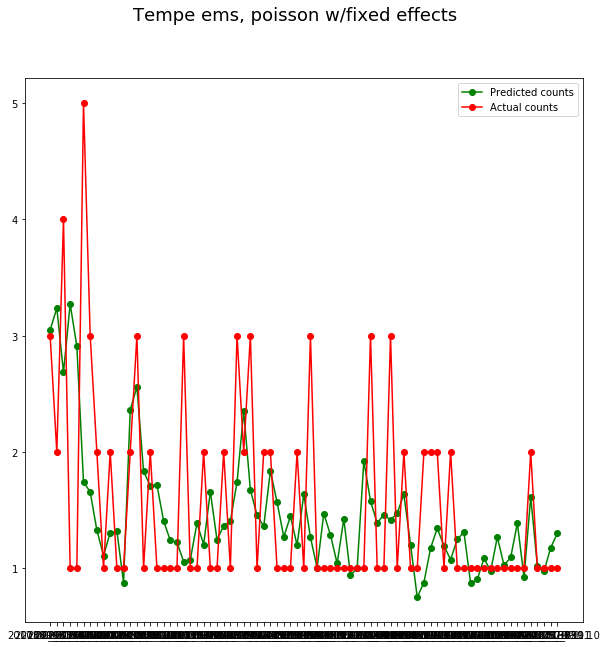

<Figure size 432x288 with 0 Axes>

In [69]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test
fig = plt.figure(figsize=(10,10))
fig.suptitle('Tempe ems, poisson w/fixed effects', size=18)
predicted, = plt.plot(predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()
plt.savefig('Tempe_EMS_Poisson_wFE')